### TODO: 
    1. Feature Engineering: class video, Prince's Post (copy exactly what he does) and other Kaggle posts.
    4. Try extremly randomized tree models
    6. Unbalanced dataset (in later ML classes)
    7. Use prun to invesitgate which line takes the most of time within one function.
    8. lesson4 video : 1:09 --> Feature Importance
    9. ----- TODO ----: I did not tune current model. Do that and do other steps

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import statistics
import math

## Define Functions

In [81]:
# model metric from Kaggle
def gini(actuals, preds, cmpcol = 0, sortcol = 1):
     assert( len(actuals) == len(preds) )
     all = np.asarray(np.c_[ actuals, preds, np.arange(len(actuals)) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actuals) + 1) / 2.
     return giniSum / len(actuals)
 
def gini_normalized(actuals, preds):
    return abs(gini(actuals, preds) / gini(actuals, actuals))

gini_score = make_scorer(gini_normalized, greater_is_better=True, needs_proba=True)

def print_score(m, X_train, X_test, y_train, y_test):
    preds_train = m.predict_proba(X_train)
    preds_test = m.predict_proba(X_test)
    preds1 = [row[1] for row in preds_train]
    preds2 = [row[1] for row in preds_test]
    res = [gini_normalized(y_train, preds1), gini_normalized(y_test, preds2),
                m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    # print(res)
    return res

# Write prediction result to local file
def writeTOfile(nums1, nums2, fname):
    # nums is id list, and nums2 is probabilities of preidiction
    if len(nums1)!=len(nums2): return
    s = "id,target\n"
    for i in range(0, len(nums1)):
        s += str(nums1[i]) + "," + str(nums2[i]) + "\n"
    f = open(f'{PATH}{fname}', 'w')
    f.write(s)
    
def split_vals(df, n): return df[:n].copy(), df[n:].copy()

## Preprocessing Data

In [3]:
PATH = "data/"
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory = False)

In [82]:
# df is used for non-feature engineering
df = df_raw.copy()

In [83]:
# df1 is used for feature engineering
df1 = df_raw.copy()

In [84]:
df.shape

(595212, 59)

In [55]:
df[0:2]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0


## EDA & Feature Engineering
- Features that belong to similar groupings are tagged as such in the feaure names (ind, reg, car, calc)
- bin -> Binary feature; cat -> categorical features; Others are either continuous or ordinal.
- -1 refers to missing values

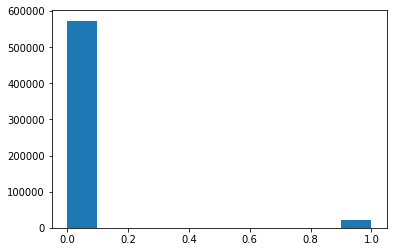

Percentage of claims filed : 3.64475178592 %


In [56]:
# distribution of response varaible 'target'
plt.hist(df1['target'])
plt.show()
print('Percentage of claims filed :' , str(np.sum(df1['target'])/df1.shape[0]*100), '%')

### Let us handle missing values first

In [85]:
## Perentage of missing values in each column.
missing = np.sum(df1 == -1)/df1.shape[0]*100
print("Percentage of missing values (denoted by -1)")
print(missing[missing > 0].sort_values(ascending = False))
missing_vars = missing[missing > 0].index

Percentage of missing values (denoted by -1)
ps_car_03_cat    69.089837
ps_car_05_cat    44.782531
ps_reg_03        18.106490
ps_car_14         7.160474
ps_car_07_cat     1.930237
ps_ind_05_cat     0.975955
ps_car_09_cat     0.095596
ps_ind_02_cat     0.036290
ps_car_01_cat     0.017977
ps_ind_04_cat     0.013945
ps_car_11         0.000840
ps_car_02_cat     0.000840
ps_car_12         0.000168
dtype: float64


1. Create a column varname_NA for each row with NAs
2. Replace -1 with mean for continuous variables
3. Create a new column counting number of NAs in current row

In [86]:
for var_name in missing_vars:
    if "ps_car_12" in var_name: continue
    is_null = (df1[var_name] == -1)
    df1[var_name + "_NA"] = is_null.astype(int)
    if 'cat' not in var_name:
        is_not_null = [not b for b in is_null]
        df1[var_name][is_null] = sum(df1[var_name][is_not_null]) / sum(is_not_null)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [87]:
df1['num_NAs'] = (df1 == -1).sum(axis=1)

In [88]:
## Now all columns (except categorical ones) have no missing values. Keep ps_car_12 
## for being compatible with test dataset
missing = np.sum(df1 == -1)/df1.shape[0]*100
print("Percentage of missing values (denoted by -1)")
print(missing[missing > 0].sort_values(ascending = False))
missing_vars = missing[missing > 0].index

Percentage of missing values (denoted by -1)
ps_car_03_cat    69.089837
ps_car_05_cat    44.782531
ps_car_07_cat     1.930237
ps_ind_05_cat     0.975955
ps_car_09_cat     0.095596
ps_ind_02_cat     0.036290
ps_car_01_cat     0.017977
ps_ind_04_cat     0.013945
ps_car_02_cat     0.000840
ps_car_12         0.000168
dtype: float64


In [61]:
df1.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', '

Based on explanation from Kaggle, 'bin' refers to binary variable, 'cat' refers to categorical variable, and others are continuous and ordinal ('cat' should mean Nominal variable here). We should take care of 'cat' variable, and leave others as they are. This is because categorical variables in this example don't have order embedded, there is no meaning to treat them as numeric variables.

In [89]:
# Comment for experiment. May use it later
for col in df1:
    if 'cat' in col and 'NA' not in col:
        df1 = df1.join(pd.get_dummies(df1[col], prefix = col))
        df1 = df1.drop(col, axis=1)

In [90]:
df1.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_03', 'ps_ind_06_bin',
       'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin',
       'ps_ind_11_bin',
       ...
       'ps_car_11_cat_95', 'ps_car_11_cat_96', 'ps_car_11_cat_97',
       'ps_car_11_cat_98', 'ps_car_11_cat_99', 'ps_car_11_cat_100',
       'ps_car_11_cat_101', 'ps_car_11_cat_102', 'ps_car_11_cat_103',
       'ps_car_11_cat_104'],
      dtype='object', length=242)

In [91]:
# Add round(ps_car_13^2 * 48400, 2)
# df1["ps_car_13"]^2*48400
# df1["ps_car_13_new"] = [round(math.pow(item, 2)*48400, 2) for item in df1["ps_car_13"]]
df1["ps_car_13_new"] = [round(math.pow(item, 2)*90000, 2) for item in df1["ps_car_13"]]

## Random Forests

### Training VS Validation

In [92]:
# Convert 'target' to categorical variable
df['target'] = df['target'].astype('category')
df1['target'] = df1['target'].astype('category')

In [93]:
X1 = df1.drop('target', axis = 1)
y1 = df1.iloc[:,1]
# train_test split on the original dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.30, random_state = 99)

In [94]:
X = df.drop('target', axis = 1)
y = df.iloc[:,1]
# train_test split on the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 99)

In [95]:
X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape

((416648, 242), (416648,), (178564, 242), (178564,))

In [96]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((416648, 58), (416648,), (178564, 58), (178564,))

### Let us check if feature engineering help for classification ###

Perform according transformation on test dataset

In [97]:
# Load in test dataset
test_df = pd.read_csv(f'{PATH}test.csv', low_memory = False)

In [98]:
## Perentage of missing values in each column.
missing = np.sum(test_df == -1)/test_df.shape[0]*100
print("Percentage of missing values (denoted by -1)")
print(missing[missing > 0].sort_values(ascending = False))
missing_vars = missing[missing > 0].index

Percentage of missing values (denoted by -1)
ps_car_03_cat    69.097216
ps_car_05_cat    44.842274
ps_reg_03        18.109442
ps_car_14         7.146489
ps_car_07_cat     1.941161
ps_ind_05_cat     0.975565
ps_car_09_cat     0.098229
ps_ind_02_cat     0.034386
ps_car_01_cat     0.017921
ps_ind_04_cat     0.016241
ps_car_02_cat     0.000560
ps_car_11         0.000112
dtype: float64


In [99]:
for var_name in missing_vars:
    is_null = (test_df[var_name] == -1)
    test_df[var_name + "_NA"] = is_null.astype(int)
    if 'cat' not in var_name:
        is_not_null = [not b for b in is_null]
        test_df[var_name][is_null] = sum(test_df[var_name][is_not_null]) / sum(is_not_null)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [100]:
test_df['num_NAs'] = (test_df == -1).sum(axis=1)

In [101]:
## Perentage of missing values in each column.
missing = np.sum(test_df == -1)/test_df.shape[0]*100
print("Percentage of missing values (denoted by -1)")
print(missing[missing > 0].sort_values(ascending = False))
missing_vars = missing[missing > 0].index

Percentage of missing values (denoted by -1)
ps_car_03_cat    69.097216
ps_car_05_cat    44.842274
ps_car_07_cat     1.941161
ps_ind_05_cat     0.975565
ps_car_09_cat     0.098229
ps_ind_02_cat     0.034386
ps_car_01_cat     0.017921
ps_ind_04_cat     0.016241
ps_car_02_cat     0.000560
dtype: float64


In [102]:
for col in test_df:
    if 'cat' in col and 'NA' not in col:
        test_df = test_df.join(pd.get_dummies(test_df[col], prefix = col))
        test_df = test_df.drop(col, axis=1)

In [103]:
len(test_df.columns)

241

In [104]:
test_df["ps_car_13_new"] = \
[round(math.pow(item, 2)*90000, 2) for item in test_df["ps_car_13"]]

### Tune Parameters without downsampling for comparison

In [29]:
# features = df.columns.drop(['id', 'target'], 1); 
rf = RandomForestClassifier(random_state=20, n_jobs = -1)
# Grid of parameters to Tune
param_grid = {"n_estimators": np.arange(1, 500, 25, dtype = int),
              "max_depth": np.arange(1, 20, 2),
              #"min_samples_split": np.arange(1,150,1),
              "min_samples_leaf": [1,5,10,20,30,50,70,100,200,300]
              #"max_leaf_nodes": np.arange(2,60,6),
              #"min_weight_fraction_leaf": np.arange(0.1,0.4, 0.1)
             }

In [30]:
param_grid

{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
 'min_samples_leaf': [1, 5, 10, 20, 30, 50, 70, 100, 200, 300],
 'n_estimators': array([  1,  26,  51,  76, 101, 126, 151, 176, 201, 226, 251, 276, 301, 326, 351, 376, 401, 426, 451, 476])}

In [31]:
%%time 
random_cv = RandomizedSearchCV(rf, param_distributions = param_grid, cv = 3, scoring = gini_score)
random_cv.fit(X1_train, y1_train)
print(random_cv.best_score_)
print(random_cv.best_params_)
print(random_cv.best_estimator_)

0.266155569614
{'n_estimators': 226, 'min_samples_leaf': 70, 'max_depth': 19}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=70, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=226, n_jobs=-1,
            oob_score=False, random_state=20, verbose=0, warm_start=False)
CPU times: user 1h 7min 52s, sys: 15.2 s, total: 1h 8min 8s
Wall time: 34min 36s


In [105]:
%%time
m = RandomForestClassifier(n_jobs=-1, max_depth=19, n_estimators=226, min_samples_leaf=70)
m.fit(X1_train, y1_train)

CPU times: user 4min 6s, sys: 248 ms, total: 4min 6s
Wall time: 2min 3s


In [106]:
print_score(m, X1_train, X1_test, y1_train, y1_test)

[0.63456250740426523,
 0.26415977208101532,
 0.96345596282713464,
 0.9637776931520351]

In [107]:
%%time
clf = RandomForestClassifier(n_jobs=-1, max_depth=19, n_estimators=226, min_samples_leaf=70)
# Fit the whole dataset
clf.fit(df1.drop(['target', 'id'], axis=1), df1.target)
# Load in test dataset
# test_df = pd.read_csv(f'{PATH}test.csv', low_memory = False)
# Predict probabilites for test data
result = clf.predict_proba(test_df.drop('id', axis=1))
predictions = [row[1] for row in result]
id_list = test_df.id.tolist()
writeTOfile(id_list, predictions, "submission5.csv")

CPU times: user 6min 47s, sys: 1.37 s, total: 6min 49s
Wall time: 3min 27s


### Tune Parameters using downsampling

** Note: CV is super expensive - use it before planning **

** Todo: Why downsampling? And How? **
Downsampling because data is unbalanced.
- 1/20 (Trues are 2500/ 50,000)
- 1/15 (Trues are 3333/ 50,000)
- 1/10 (Trues are 5000/ 50,000)

**Pick n_estimators = 357, max_depth = 9**

In [10]:
%%time
for i in range(3):
    for j in [2500, 3333, 5000]:
        index0 = df.index[df['target'] == 0]
        index1 = df.index[df['target'] == 1]
        index = random.sample(list(index0), 50000 - j) + random.sample(list(index1), j)
        df_tmp = df.ix[index]

        # splitting y and x
        X_tmp = df_tmp[features]
        y_tmp = df_tmp.iloc[:,1]
              
        random_cv = RandomizedSearchCV(rf, param_distributions = param_grid, cv = 3, scoring = gini_score)
        random_cv.fit(X_tmp, y_tmp)
        print(random_cv.best_score_)
        print(random_cv.best_params_)
        #print(random_cv.best_estimator_)

/Users/chengcheng/anaconda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


0.222150406987
{'n_estimators': 425, 'max_depth': 5}
0.264078349449
{'n_estimators': 375, 'max_depth': 9}
0.255701837486
{'n_estimators': 475, 'max_depth': 11}
0.261694942434
{'n_estimators': 375, 'max_depth': 6}
0.241504690974
{'n_estimators': 225, 'max_depth': 7}
0.241998392
{'n_estimators': 275, 'max_depth': 8}
0.262164800521
{'n_estimators': 325, 'max_depth': 7}
0.237835631964
{'n_estimators': 275, 'max_depth': 9}
0.247183548639
{'n_estimators': 425, 'max_depth': 8}
CPU times: user 1h 27min 22s, sys: 1min 46s, total: 1h 29min 9s
Wall time: 31min 52s


### Try tunned parameters on training / testing of whole dataset ##

In [55]:
%%time
m1 = RandomForestClassifier(n_jobs=-1, max_depth=13, n_estimators=176)
m1.fit(X_train, y_train)
# print_score(m1, X_train, X_test, y_train, y_test)

CPU times: user 2min 2s, sys: 120 ms, total: 2min 2s
Wall time: 1min 1s


In [56]:
print_score(m1, X_train, X_test, y_train, y_test)

[0.75318430847770046,
 0.25407439316204522,
 0.96352316583782949,
 0.96375529222015632]

In [44]:
m = RandomForestClassifier(n_jobs=-1, max_depth=7, n_estimators=200)
%time m.fit(X_train, y_train)

CPU times: user 1min 6s, sys: 64 ms, total: 1min 6s
Wall time: 33.4 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
print_score(m, X_train, X_test, y_train, y_test)

[0.32336971238523571,
 0.25379381664267314,
 0.96360958426554144,
 0.96354243232458991]

In [46]:
m2 = RandomForestClassifier(n_jobs=-1, max_depth=9, n_estimators=200)
%time m2.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 68 ms, total: 1min 23s
Wall time: 42.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
print_score(m2, X_train, X_test, y_train, y_test)

[0.42159334455920722,
 0.25651369797865187,
 0.96362358488716904,
 0.96353403196337439]

### Train on the whole dataset, and write predictions to local file ###

In [57]:
%%time
clf = RandomForestClassifier(n_jobs=-1, max_depth=13, n_estimators=176)
# Fit the whole dataset
clf.fit(df.drop(['target', 'id'], axis=1), df.target)
# Load in test dataset
test_df = pd.read_csv(f'{PATH}test.csv', low_memory = False)
# Predict probabilites for test data
result = clf.predict_proba(test_df.drop('id', axis=1))
predictions = [row[1] for row in result]
id_list = test_df.id.tolist()
writeTOfile(id_list, predictions, "submission2.csv")

CPU times: user 3min 29s, sys: 896 ms, total: 3min 30s
Wall time: 1min 50s


In [24]:
??set_rf_samples()

In [31]:
set_rf_samples(20000)

In [32]:
%%time
clf = RandomForestClassifier(n_estimators=357, max_depth=9, n_jobs=-1)
clf.fit(X_train, y_train)
print_score(m, X_train, X_test, y_train, y_test)

[0.45684294230428935, 0.26242798228386199, 0.96347095253995951, 0.96408860663793761]
CPU times: user 1min 48s, sys: 8.06 s, total: 1min 56s
Wall time: 34.4 s


** Decreasing n_esitmators to 100 doesn't seem to affect gini too much **

In [34]:
%%time
clf = RandomForestClassifier(n_estimators=100, max_depth=9, n_jobs=-1)
clf.fit(X_train, y_train)
print_score(m, X_train, X_test, y_train, y_test)

[0.45683329769547293, 0.26242656338930015, 0.96347095253995951, 0.96408860663793761]
CPU times: user 58.3 s, sys: 3.98 s, total: 1min 2s
Wall time: 18.4 s


** Manually tune min_samples **

In [38]:
%%time
clf = RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_leaf=3, n_jobs=-1)
clf.fit(X_train, y_train)
print_score(m, X_train, X_test, y_train, y_test)

[0.4568334140704659, 0.26243158252494841, 0.96347095253995951, 0.96408860663793761]
CPU times: user 1min 9s, sys: 5.36 s, total: 1min 14s
Wall time: 24.9 s


 ** Manually tune max_features **

In [39]:
%%time
clf = RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_leaf=3,max_features=0.5, n_jobs=-1)
clf.fit(X_train, y_train)
print_score(m, X_train, X_test, y_train, y_test)

[0.45683441639701722, 0.26243392696280193, 0.96347095253995951, 0.96408860663793761]
CPU times: user 1min 46s, sys: 5.01 s, total: 1min 51s
Wall time: 34.3 s


** Seems like both min_samples_leaf and max_features work, let us tune them using grid search **

In [60]:
depths = np.arange(1, 20, 2)
nums_feature = np.arange(0.1, 0.9, 0.1)
nums_leaf = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,70,90]
preds = {}

for depth in depths:
    for num_feature in nums_feature:
        for num_leaf in nums_leaf:
            clf = RandomForestClassifier(n_estimators=100, max_depth=depth, min_samples_leaf=num_leaf,max_features=num_feature, n_jobs=-1)
            clf.fit(X_train, y_train)
            print(depth, num_feature, num_leaf)
            result = print_score(m, X_train, X_test, y_train, y_test) 
            preds[str(depth)+str(num_feature)+str(num_leaf)] = result[1]

1 0.1 1
1 0.1 2
1 0.1 3
1 0.1 4
1 0.1 5
1 0.1 6
1 0.1 7
1 0.1 8
1 0.1 9
1 0.1 10
1 0.1 20
1 0.1 30
1 0.1 40
1 0.1 50
1 0.1 70
1 0.1 90
1 0.2 1
1 0.2 2
1 0.2 3
1 0.2 4
1 0.2 5
1 0.2 6
1 0.2 7
1 0.2 8
1 0.2 9
1 0.2 10
1 0.2 20
1 0.2 30
1 0.2 40
1 0.2 50
1 0.2 70
1 0.2 90
1 0.3 1
1 0.3 2
1 0.3 3
1 0.3 4
1 0.3 5
1 0.3 6
1 0.3 7
1 0.3 8
1 0.3 9
1 0.3 10
1 0.3 20
1 0.3 30
1 0.3 40
1 0.3 50
1 0.3 70
1 0.3 90
1 0.4 1
1 0.4 2
1 0.4 3
1 0.4 4
1 0.4 5
1 0.4 6
1 0.4 7
1 0.4 8
1 0.4 9
1 0.4 10
1 0.4 20
1 0.4 30
1 0.4 40
1 0.4 50
1 0.4 70
1 0.4 90
1 0.5 1
1 0.5 2
1 0.5 3
1 0.5 4
1 0.5 5
1 0.5 6
1 0.5 7
1 0.5 8
1 0.5 9
1 0.5 10
1 0.5 20
1 0.5 30
1 0.5 40
1 0.5 50
1 0.5 70
1 0.5 90
1 0.6 1
1 0.6 2
1 0.6 3
1 0.6 4
1 0.6 5
1 0.6 6
1 0.6 7
1 0.6 8
1 0.6 9
1 0.6 10
1 0.6 20
1 0.6 30
1 0.6 40
1 0.6 50
1 0.6 70
1 0.6 90
1 0.7 1
1 0.7 2
1 0.7 3
1 0.7 4
1 0.7 5
1 0.7 6
1 0.7 7
1 0.7 8
1 0.7 9
1 0.7 10
1 0.7 20
1 0.7 30
1 0.7 40
1 0.7 50
1 0.7 70
1 0.7 90
1 0.8 1
1 0.8 2
1 0.8 3
1 0.8 4
1 0.8 5
1 0.8 6
1 0.8 7

15 0.3 10
15 0.3 20
15 0.3 30
15 0.3 40
15 0.3 50
15 0.3 70
15 0.3 90
15 0.4 1
15 0.4 2
15 0.4 3
15 0.4 4
15 0.4 5
15 0.4 6
15 0.4 7
15 0.4 8
15 0.4 9
15 0.4 10
15 0.4 20
15 0.4 30
15 0.4 40
15 0.4 50
15 0.4 70
15 0.4 90
15 0.5 1
15 0.5 2
15 0.5 3
15 0.5 4
15 0.5 5
15 0.5 6
15 0.5 7
15 0.5 8
15 0.5 9
15 0.5 10
15 0.5 20
15 0.5 30
15 0.5 40
15 0.5 50
15 0.5 70
15 0.5 90
15 0.6 1
15 0.6 2
15 0.6 3
15 0.6 4
15 0.6 5
15 0.6 6
15 0.6 7
15 0.6 8
15 0.6 9
15 0.6 10
15 0.6 20
15 0.6 30
15 0.6 40
15 0.6 50
15 0.6 70
15 0.6 90
15 0.7 1
15 0.7 2
15 0.7 3
15 0.7 4
15 0.7 5
15 0.7 6
15 0.7 7
15 0.7 8
15 0.7 9
15 0.7 10
15 0.7 20
15 0.7 30
15 0.7 40
15 0.7 50
15 0.7 70
15 0.7 90
15 0.8 1
15 0.8 2
15 0.8 3
15 0.8 4
15 0.8 5
15 0.8 6
15 0.8 7
15 0.8 8
15 0.8 9
15 0.8 10
15 0.8 20
15 0.8 30
15 0.8 40
15 0.8 50
15 0.8 70
15 0.8 90
17 0.1 1
17 0.1 2
17 0.1 3
17 0.1 4
17 0.1 5
17 0.1 6
17 0.1 7
17 0.1 8
17 0.1 9
17 0.1 10
17 0.1 20
17 0.1 30
17 0.1 40
17 0.1 50
17 0.1 70
17 0.1 90
17 0.2 1
17 0.2 2
17 0.2

In [62]:
preds

{'10.11': 0.26241895925608788,
 '10.12': 0.262403192401862,
 '10.13': 0.26244958373038096,
 '10.14': 0.26242829215738689,
 '10.15': 0.2624070413572252,
 '10.16': 0.26241086177160561,
 '10.17': 0.26242607819259645,
 '10.18': 0.26242792927918002,
 '10.19': 0.26242358289526357,
 '10.110': 0.26243159883408135,
 '10.120': 0.26246024582601074,
 '10.130': 0.26242792927918002,
 '10.140': 0.26240667847901833,
 '10.150': 0.26242031291411816,
 '10.170': 0.26240688642046278,
 '10.190': 0.26242792927918002,
 '10.21': 0.26242599664693195,
 '10.22': 0.26243372309864088,
 '10.23': 0.2624290301456505,
 '10.24': 0.26242389684607187,
 '10.25': 0.26246271665964438,
 '10.26': 0.26241623970817762,
 '10.27': 0.26242903830021669,
 '10.28': 0.26243216965373262,
 '10.29': 0.26243468941476494,
 '10.210': 0.26240351858451993,
 '10.220': 0.26244884574211741,
 '10.230': 0.26243227566309651,
 '10.240': 0.26242643291623685,
 '10.250': 0.26243539070747918,
 '10.270': 0.26241971355348437,
 '10.290': 0.26239177193155244

In [63]:
max_score = 0
par = ""
for key in preds:
    if preds[key] > max_score: 
        max_score = preds[key]
        par = key
print(max_score)
print(par)

0.262483490418
130.770


In [72]:
%%time
reset_rf_samples()
clf = RandomForestClassifier(n_estimators=175, max_depth=10, max_leaf_nodes=50,n_jobs=-1)
# Fit the whole dataset
clf.fit(df.drop(['target', 'id'], axis=1), df.target)
# Load in test dataset
test_df = pd.read_csv(f'{PATH}test.csv', low_memory = False)
# Predict probabilites for test data
result = clf.predict_proba(test_df.drop('id', axis=1))
predictions = [row[1] for row in result]
id_list = test_df.id.tolist()
writeTOfile(id_list, predictions, "submission3.csv")

CPU times: user 6min 45s, sys: 9.84 s, total: 6min 55s
Wall time: 2min 16s


In [67]:
??set_rf_samples()